In [1]:
## Digit recognizer 
# In this Jupyter Notebook, we build a series of machine learning methods to recognize digits 
# from images. The data has been take from the Kaggle competition.

# Import  default modules
import os
import numpy as np
import pandas as pd
from abc import ABC, abstractmethod

# Import visualization modules
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Import ML modules
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, SCORERS
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_validate, \
    cross_val_score, RepeatedKFold, KFold, StratifiedKFold, GridSearchCV
from lightgbm import LGBMClassifier

Using TensorFlow backend.


In [32]:
# Configuration - Initial Parameters used for optimization of the ML algorithms
BATCH_SIZE = 64
EPOCHS = 50
K = 2
RND = 13

In [41]:
# Define here the preprocessing steps
def pipeline_tf(df):
    return df.iloc[:, 1:].values.astype('float32').reshape(-1, 28, 28, 1) / 255.0, df.iloc[:, :1].values
    
def pipeline_sk(df):
    scaler = StandardScaler()     
    return scaler.fit_transform(df.iloc[:, 1:]), df.iloc[:, :1]

# Define Abstract class   
class DataReader(ABC):  
    def __init__(self, path, pipeline=None, file=None):
        self._path = path
        self._path_file = os.path.join(self._path, file)
        self._data = None
        self._pipeline = pipeline
        self.x = None
        self.y = None
        self.tensor = None
        
    def _read(self):
        self._data = pd.read_csv(self._path_file)
    
    def _format(self):
        if self._pipeline is not None:
            return self._pipeline(self._data)
        else:
            return self._data, None
    
    @abstractmethod
    def get(self):
        return None
        
# Define specific class for scikit-learn
class ReaderSK(DataReader):
    def __init__(self, path, pipeline, file='train.csv'):
         super().__init__(path=path, pipeline=pipeline, file=file)
        
    def get(self):
        self._read()
        self.x, self.y = self._format()  
        return self.x, self.y
 
# Define specific class for tensorflow/keras 
class ReaderTF(DataReader):
    def __init__(self, path, pipeline,  file='train.csv'):
         super().__init__(path=path, pipeline=pipeline, file=file)
        
    def get(self):
        self._read()
        self.x, self.y = self._format()  
        return self.x, self.y

class ModelItinerator(ABC):    
    @abstractmethod
    def train(self):
            return None
               
    @abstractmethod
    def _predict(self, x):
            return None\
    
    @abstractmethod
    def evaluate(self):
            return None
        
    @abstractmethod
    def infer(self):
            return None

class ModelSK(ModelItinerator):    
    def __init__(self, models, params=None, scoring=None, reader=ReaderSK, pipeline=pipeline_sk):
        self._models = models
        self._params = params
        self._scoring = scoring
        self._scores = []
        self._preds = []
        self._reader_train = reader(path='./data/', pipeline=pipeline)
        self._reader_test = reader(path='./data/', pipeline=pipeline, file='test.csv')
        self._x_train = None
        self._y_train = None
        self._x_test = None
        super().__init__()
    
    def train(self):        
        # Extract data
        self._scores = []
        self._x_train, self._y_train  = self._reader_train.get()
        
        # Run cross-validation
        cv = KFold(n_splits=K, random_state=RND)        
        for i, model in enumerate(self._models):
            if self._params is not None:
                clf = GridSearchCV(model, param_grid=self._params, cv=cv)
                clf.fit(self._x_train, self._y_train)
                self._models[i] = clf.best_estimator_
                print(clf.best_params_)            
                self._scores.append(clf.best_score_)
            elif self._scoring is None:
                scores = cross_val_score(model, self._x_train, self._y_train, cv=cv)
                print(scores)
                print(type(scores))
                self._scores.append(np.mean(scores))
            else:
                scores = cross_validate(model, self._x_train, self._y_train, cv=cv, scoring=scoring)      
                print(scores)
                print(type(scores))
                self._scores.append(scores)  

    def _predict(self, x):
        self._preds = []
        for i, model in enumerate(self._models):
            self._preds.append(model.predict(x))
        return self._preds
            
    def evaluate(self):
        return self._predict(self._x_train)
    
    def infer(self):
        self._x_test, _  = self._reader_train.get()
        return self._predict(self._x_train)

In [ ]:
scoring = ['precision_macro', 'recall_macro', 'f1_macro', 'roc_auc_ovr_weighted']        
parameters = [{'C':[1, 10, 50. / 5000]}]
models = [RandomForestClassifier(n_estimators = 500, random_state=RND)]

# models = [LogisticRegression(C= penalty='l1', solver='saga', tol=0.1, random_state=RND),
#               RandomForestClassifier(n_estimators = 500, random_state=RND),
#               LGBMClassifier(random_state=RND)]

#SVC(probability=True)
model = ModelSK(models=models)   
model.train()
print(model._scores)

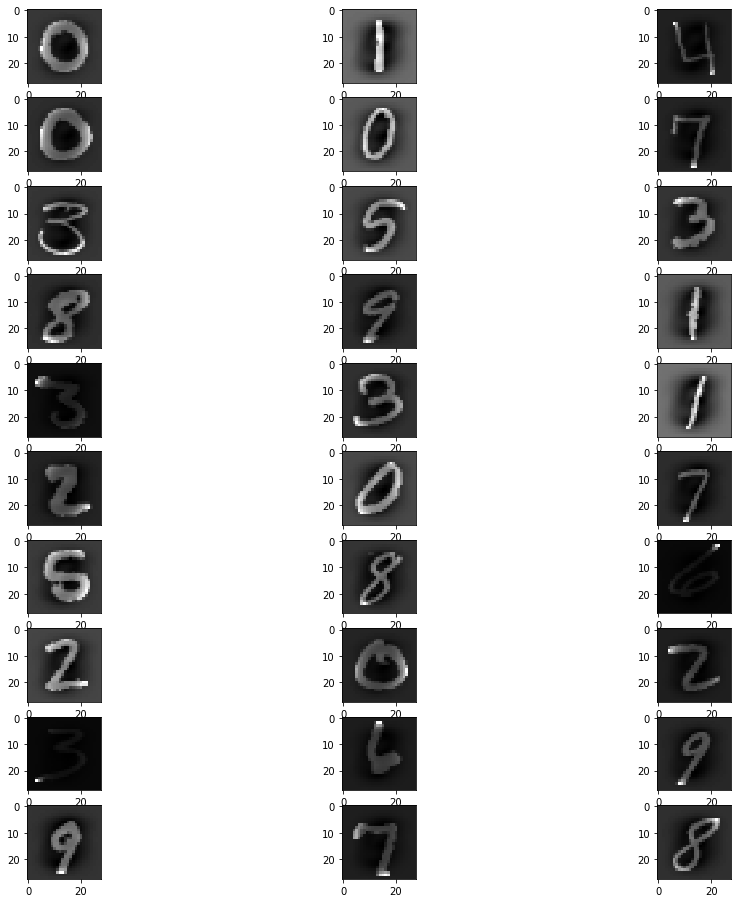

In [29]:
# Visualization 
rows = 10
cols = 3
fig = plt.figure(figsize=(16, 16))
for i in range(1, cols * rows + 1):        
    img, _ = ReaderSK(path='./data/', pipeline=pipeline_sk).get()
    img = img[i, :].reshape((28,28))
    fig.add_subplot(rows, cols, i)
    plt.imshow(img, cmap='gray')
plt.show()

In [33]:
#  Deep learning - Architecture
def get_compiled_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, 3, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, 3, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.25),  
    tf.keras.layers.Flatten(),                        
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25), 
    tf.keras.layers.Dense(10, activation='softmax')
  ])
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [36]:
# Training - Deep learning 
model = KerasClassifier(build_fn=get_compiled_model, 
                                 epochs=10, 
                                 batch_size=64, 
                                 verbose=1)
models = [model]
model = ModelSK(models=models, reader=ReaderTF, pipeline=pipeline_tf)  
model.train()

C:\Projects\venv\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Train on 21000 samples
Epoch 1/10
21000/21000 [==============================] - 4s 191us/sample - loss: 1.2565 - accuracy: 0.5908
Epoch 2/10
21000/21000 [==============================] - 3s 149us/sample - loss: 0.7507 - accuracy: 0.7689
Epoch 3/10
21000/21000 [==============================] - 3s 125us/sample - loss: 0.6543 - accuracy: 0.8015
Epoch 4/10
21000/21000 [==============================] - 3s 139us/sample - loss: 0.5824 - accuracy: 0.8219
Epoch 5/10
21000/21000 [==============================] - 3s 131us/sample - loss: 0.5416 - accuracy: 0.8334
Epoch 6/10
21000/21000 [==============================] - 3s 140us/sample - loss: 0.5006 - accuracy: 0.8457
Epoch 7/10
21000/21000 [==============================] - 3s 134us/sample - loss: 0.4728 - accuracy: 0.8531
Epoch 8/10
21000/21000 [==============================] - 3s 131us/sample - loss: 0.4526 - accuracy: 0.8588
Epoch 9/10
21000/21000 [==============================] - 3s 131us/sample - loss: 0.4440 - accuracy: 0.8637
Epoch

In [40]:
# Training - Deep learning (Manual)
reader_train = ReaderTF(path='./data/', pipeline=pipeline_tf)
reader_test = ReaderTF(path='./data/', pipeline=pipeline_tf, file='test.csv')
print("&&&&&&&&&&&&&&&&&&&&")
x_train, y_train = reader_train.get()
print("&&&&&&&&&&&&&&&&&&&&")
x_test, y_test = reader_test.get()

&&&&&&&&&&&&&&&&&&&&
       label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0          1       0       0       0       0       0       0       0       0   
1          0       0       0       0       0       0       0       0       0   
2          1       0       0       0       0       0       0       0       0   
3          4       0       0       0       0       0       0       0       0   
4          0       0       0       0       0       0       0       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
41995      0       0       0       0       0       0       0       0       0   
41996      1       0       0       0       0       0       0       0       0   
41997      7       0       0       0       0       0       0       0       0   
41998      6       0       0       0       0       0       0       0       0   
41999      9       0       0       0       0       0       0       0       0   

       pixel8  ...

ValueError: cannot reshape array of size 21924000 into shape (28,28,1)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = dataset.shuffle(x_train.shape[0]).batch(64)
model = get_compiled_model()
model.fit(x_train, y_train, batch_size=BATCH_SIZE, nb_epoch=EPOCHS, verbose=1)
score = model.evaluate(x_train, y_train, verbose=0)
print(score)

In [41]:
# Inference 

# 10. Evaluate model on test data
score = model.evaluate(x_train, y_train, verbose=0)

# 11. Predict model on test data
predicted_labels = model.predict_classes(x_test).astype(int)

## 12. Write to file
df = pd.DataFrame(data=predicted_labels)
df.columns = ['Label']
df.index += 1
df.index.name = 'ImageId'
df.to_csv('predicted_labels.csv', index=True)
print(predicted_labels)

def generator(preds):
    df = pd.DataFrame(data=preds)
    df.columns = ['Label']
    df.index += 1
    df.index.name = 'ImageId'
    df.to_csv('predicted_labels.csv', index=True)

(28000, 28, 28, 1)
(21952000,)
[0.13863920398766086, 0.9603571]
[2 0 9 ... 3 9 2]
